# _littleglyphs_ - glyph generation using siamese network classification

### Setup the environment

Import the project library for glyph generation, classification, plotting, etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import littleglyphs as lilg
import littleglyphs.plotting as lilgplt
import littleglyphs.classification as lilgcls
import littleglyphs.examples as lilgex
import littleglyphs.generation as lilggen

import importlib
importlib.reload(lilg)
importlib.reload(lilgplt)
importlib.reload(lilgcls)
importlib.reload(lilgex)
importlib.reload(lilggen)

/home/incide/miniconda3/envs/py36_for_tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/incide/miniconda3/envs/py36_for_tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/incide/miniconda3/envs/py36_for_tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/hom

<module 'littleglyphs.generation' from '/home/incide/projects/littleglyphs/littleglyphs/generation.py'>

Import the libraries required for this notebook.

In [3]:
import copy
import time

import numpy as np
import scipy
from scipy import signal as scipy_signal
import skimage
import sklearn 
import matplotlib.pyplot as plt

import tensorflow as tf
import keras


Some examples generate data randomly. Seed the random number generator for consistent results.

In [4]:
random_seed = 456
np.random.seed(random_seed)

### Broad random search of glyph space for initial good guess

Generate a large glyph alphabet to broadly search glyph space for a set of potentially good candidates.

In [5]:
# How many glyphs in total do we want in our alphabet
N_glyphs_in_alphabet = 80

# How many slight variations of each glyph do we want
N_glyph_permutations = 5
permutation_strength = 0.08

# What parameters to use to generate glyph images
imgsize = 16

# What parameters to use to distort generated images
N_glyph_raster_distortions = 5
rotat_distort_max = np.pi / 6
shear_distort_max = np.pi / 12
scale_distort_max = 0.25

blur_factor = 1


time_start = time.time()
print('Generating glyph alphabet and rasters... ', end='')

#glyph_gens = []
#glyph_gens.append(lilggen.RandomGlyphGenerator())
#glyph_gens[0].add_feature(lilg.FeatureLineSegment, feature_count=2)
#glyph_gens.append(lilggen.RandomGlyphGenerator())
#glyph_gens[1].add_feature(lilg.FeatureLineSegment, feature_count=3)
#glyph_gens.append(lilggen.RandomGlyphGenerator())
#glyph_gens[2].add_feature(lilg.FeatureLineSegment, feature_count=1)
#glyph_gens[2].add_feature(lilg.FeatureMultiPointLineSegment, feature_count=1, N_points=3)
#alphabet_generator = lilggen.RandomAlphabetGenerator(glyph_gens,weights=[1,0.5,0.5])
alphabet_generator = lilgex.basic_random_glyph_generator()

glyph_categories = list(range(0,N_glyphs_in_alphabet))
glyph_alphabet = alphabet_generator.generate_random_glyph_alphabet(glyph_categories)
glyph_permuted_alphabet = glyph_alphabet.permuted(permutation_strength, N_glyph_permutations)

glyph_rasters = glyph_permuted_alphabet.render(
    (imgsize,imgsize), 
    blur_factor=blur_factor,randomize_blur=True,random_blur_extent=2
)
distorter = lilg.SequentialDistorter(
    [lilg.DistortionRandomAffine(
        rotat_distort_max = rotat_distort_max, 
        shear_distort_max = shear_distort_max,
        scale_distort_max = scale_distort_max
    )])
glyph_rasters = glyph_rasters.distorted(distorter, N_glyph_raster_distortions)

time_end = time.time()
print('done in '+'{0:.3f}'.format(time_end-time_start)+' sec '+
     '('+'{0:.3f}'.format((time_end-time_start)/N_glyphs_in_alphabet)+' sec per glyph).')


Generating glyph alphabet and rasters... done in 3.362 sec (0.042 sec per glyph).


Visualize the glyphs and show some examples of glyph rasters.

Ground truth glyphs:


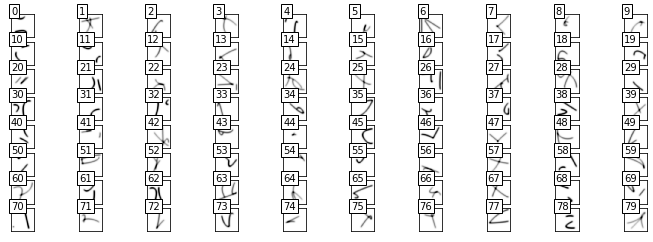

In [6]:
print('Ground truth glyphs:')
fig, axs = lilgplt.visualize_glyph_list(
    glyph_alphabet,
    N_glyphs_to_show = N_glyphs_in_alphabet, 
    imgsize=128, 
    blur_factor=0.5*16,
    figsize=(12,4)
)
plt.show()

Examples of glyph images:


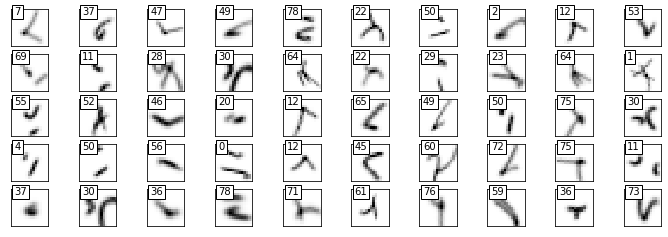

In [7]:
print('Examples of glyph images:')
N_images_to_show = 50

random_indices = np.arange(len(glyph_rasters))
np.random.shuffle(random_indices)
vis_imgs = glyph_rasters[random_indices[0:N_images_to_show]]
vis_categories = glyph_rasters.categories[random_indices[0:N_images_to_show]]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,figsize=(12,4))
plt.show()

### Loading a Siamese CNN model

For classification, a Siamese CNN model is used. More details on this model are available in the siamese network notebook.

In [8]:
model_dir = './saved_models/'
model_filename = 'siamese_CNN_model_16x16_5x10epoch_120newsymb.h5'
model_path = model_dir + model_filename

# Loading model with Lambda layers (and any other custom functionality) requires feeding names. 
# This includes stuff that relies on backend if it wasn't imported via 'import keras.backend as K'.
# See https://github.com/keras-team/keras/issues/4609 for more workarounds.
model = keras.models.load_model(
    model_path, 
    custom_objects={
        'keras': keras,
        'keras.backend': keras.backend
    }
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.


### Similarity matrices

In [9]:
siamese_classifier = lilgcls.SiameseCNN_classifier(model, glyph_rasters)

subsample_size = 3
similarity_matrix, Y_predicted = siamese_classifier.similarity_matrix(subsample_size)

(2, 57600, 16, 16)


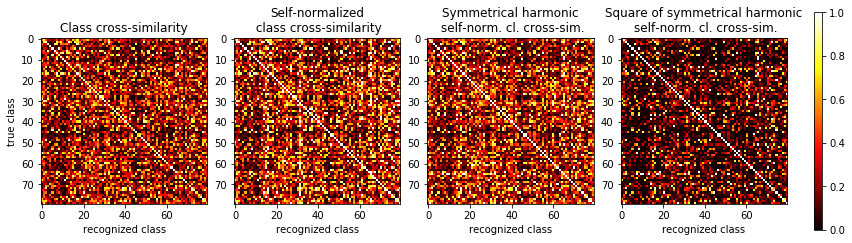

In [10]:
def symmetric_harmonic_mean(M):
    return np.sqrt(np.multiply(M,np.transpose(M)))

similarity_matrix_normself = np.diagonal(similarity_matrix)
similarity_matrix_normself = np.divide(similarity_matrix,similarity_matrix_normself)

fig,ax = plt.subplots(1,5,figsize=(14,4),gridspec_kw={"width_ratios":[1,1,1,1, 0.05]})
im = ax[0].imshow(similarity_matrix,vmin=0, vmax=1,cmap='hot')
ax[0].set_title("Class cross-similarity");ax[0].set_ylabel("true class");ax[0].set_xlabel("recognized class")

ax[1].imshow(similarity_matrix_normself, vmin=0, vmax=1, cmap='hot')
ax[1].set_title("Self-normalized\n class cross-similarity"); ax[1].set_xlabel("recognized class")

ax[2].imshow(
    symmetric_harmonic_mean(similarity_matrix_normself), 
    vmin=0, vmax=1, cmap='hot'
)
ax[2].set_title("Symmetrical harmonic\n self-norm. cl. cross-sim."); ax[2].set_xlabel("recognized class")

ax[3].imshow(
    np.square(symmetric_harmonic_mean(similarity_matrix_normself)), 
    vmin=0, vmax=1, cmap='hot'
)
ax[3].set_title("Square of symmetrical harmonic\n self-norm. cl. cross-sim."); ax[3].set_xlabel("recognized class")
fig.colorbar(im,cax=ax[4])
plt.show()

Take the subset of glyphs that are least likely to be misclassified to each other, using the square of self-normalized cross-similarity as a metric.

In [11]:
N_best_glyphs = 20
costmatrix = np.square(symmetric_harmonic_mean(similarity_matrix_normself))

best_glyph_indices = lilgcls.find_lowest_cross_similarity_greedy(costmatrix,N_best_glyphs)
print(best_glyph_indices)

[58 64 54 47 10 11 62 44  9 63 48 38  6 14  4 49 41 57 68  5]


[ 4  5  6  9 10 11 14 38 41 44 47 48 49 54 57 58 62 63 64 68]


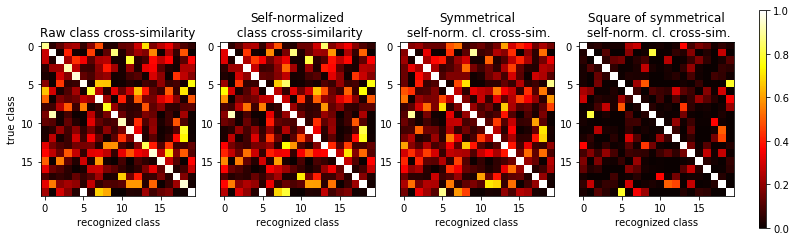

Sum of normalized cross-similarities (excluding diagonal): 77.46457
Sum of squares of normalized cross-similarities (excluding diagonal): 30.971817


In [12]:
s = np.sort(best_glyph_indices)
print(s)
ixgrid = np.ix_(s, s)
similarity_matrix_subset = similarity_matrix[ixgrid]

fig,ax = plt.subplots(1,5,figsize=(13,4),gridspec_kw={"width_ratios":[1,1,1,1, 0.05]})

ax[0].imshow(similarity_matrix_subset, vmin=0, vmax=1, cmap='hot')
similarity_matrix_subset_normself = np.divide(similarity_matrix_subset,np.diagonal(similarity_matrix_subset))
ax[0].set_title("Raw class cross-similarity")
ax[0].set_ylabel("true class"); ax[0].set_xlabel("recognized class")

ax[1].imshow(similarity_matrix_subset_normself, vmin=0, vmax=1, cmap='hot')
ax[1].set_title("Self-normalized\n class cross-similarity"); ax[1].set_xlabel("recognized class")

ax[2].imshow(
    (similarity_matrix_subset_normself+np.transpose(similarity_matrix_subset_normself))/2, 
    vmin=0, vmax=1, cmap='hot'
)
ax[2].set_title("Symmetrical\n self-norm. cl. cross-sim."); ax[2].set_xlabel("recognized class")

ax[3].imshow(
    np.square((similarity_matrix_subset_normself+np.transpose(similarity_matrix_subset_normself))/2), 
    vmin=0, vmax=1, cmap='hot'
)
ax[3].set_title("Square of symmetrical\n self-norm. cl. cross-sim."); ax[3].set_xlabel("recognized class")

fig.colorbar(im,cax=ax[4])
plt.show()

nondiag_sum = np.sum(similarity_matrix_subset_normself) - np.sum(np.diagonal(similarity_matrix_subset_normself))
print('Sum of normalized cross-similarities (excluding diagonal): '+str(nondiag_sum))
nondiag_sq_sum = (
    np.sum(np.square(similarity_matrix_subset_normself)) - 
    np.sum(np.diagonal(np.square(similarity_matrix_subset_normself)))
)
print('Sum of squares of normalized cross-similarities (excluding diagonal): '+str(nondiag_sq_sum))

Set this subset as the new glyph alphabet to start working from.

In [13]:
glyph_alphabet_new = glyph_alphabet.selected(s)
glyph_alphabet_new.reset_categories()

Ground truth, best glyphs:


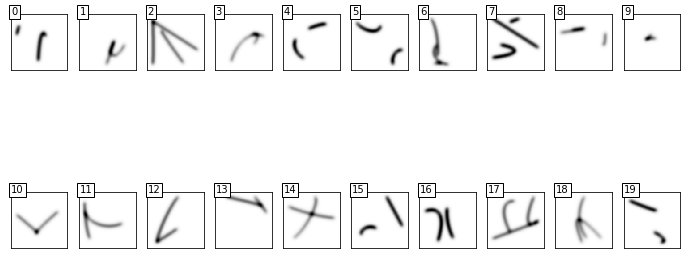

In [14]:
print('Ground truth, best glyphs:')
fig, axs = lilgplt.visualize_glyph_list(
    glyph_alphabet_new,
    N_glyphs_to_show = N_best_glyphs, 
    imgsize=128, 
    blur_factor=0.5*16,
    figsize=(12,6)
)
plt.show()

### Exploring glyph space for better candidates

Look at some examples of the current selected glyphs.

Examples of glyph images:


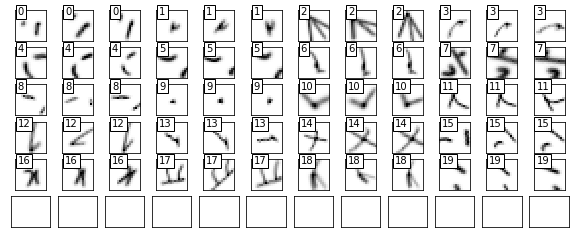

In [15]:
glyph_rasters_new = glyph_alphabet_new.render(
    (imgsize,imgsize), 
    blur_factor=blur_factor,randomize_blur=True,random_blur_extent=2
)
glyph_rasters_new = glyph_rasters_new.distorted(distorter, N_glyph_raster_distortions)

print('Examples of glyph images:')
N_images_to_show = N_best_glyphs*3

vis_indices = []
for i in range(0,glyph_rasters_new.N_different_categories):
    vis_indices += glyph_rasters_new.category_indices[i][:3]
vis_indices = np.array(vis_indices).flatten()

vis_imgs = glyph_rasters_new[vis_indices[0:N_images_to_show]]
vis_categories = glyph_rasters_new.categories[vis_indices[0:N_images_to_show]]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,figsize=(10,4))
plt.show()

For each of the selected characters, generate several mutants.

In [16]:
N_mutants = 4
mutation_strength = 0.15

glyph_mutant_alphabet = glyph_alphabet_new.permuted(mutation_strength, N_mutants-1, keep_original_glyphs=True)
glyph_mutant_alphabet.sort_by_category()
glyph_mutant_alphabet.reset_categories()

glyph_rasters_new = glyph_mutant_alphabet.render(
    (imgsize,imgsize), 
    blur_factor=blur_factor,randomize_blur=True,random_blur_extent=2
)
glyph_rasters_new = glyph_rasters_new.distorted(distorter, N_glyph_raster_distortions)

Ground truth, mutants:


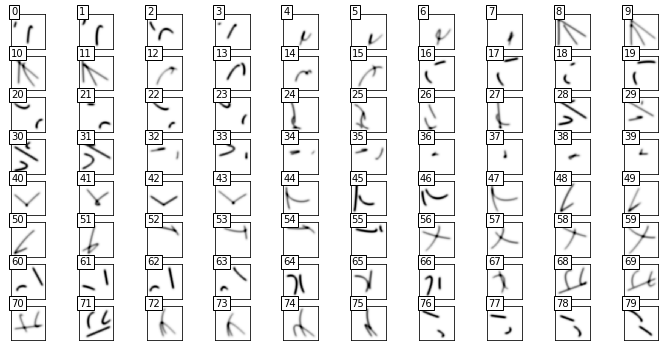

In [17]:
print('Ground truth, mutants:')
fig, axs = lilgplt.visualize_glyph_list(
    glyph_mutant_alphabet,
    N_glyphs_to_show = glyph_mutant_alphabet.N_glyphs, 
    imgsize=128, 
    blur_factor=0.5*16,
    figsize=(12,6)
)
plt.show()

In [18]:
siamese_classifier = lilgcls.SiameseCNN_classifier(model, glyph_rasters_new)

subsample_size = 3
similarity_matrix, Y_predicted = siamese_classifier.similarity_matrix(subsample_size)

(2, 57600, 16, 16)


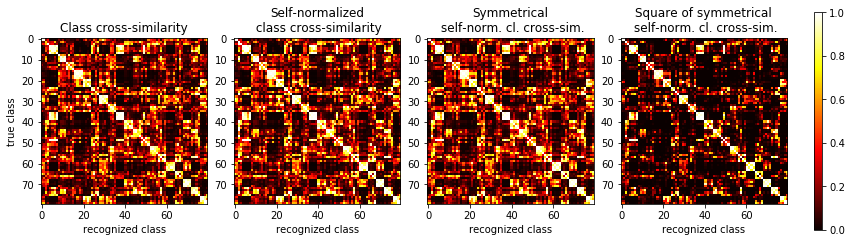

In [19]:
similarity_matrix_normself = np.diagonal(similarity_matrix)
similarity_matrix_normself = np.divide(similarity_matrix,similarity_matrix_normself)

fig,ax = plt.subplots(1,5,figsize=(14,4),gridspec_kw={"width_ratios":[1,1,1,1, 0.05]})
im = ax[0].imshow(similarity_matrix,vmin=0, vmax=1,cmap='hot')
ax[0].set_title("Class cross-similarity");ax[0].set_ylabel("true class");ax[0].set_xlabel("recognized class")

ax[1].imshow(similarity_matrix_normself, vmin=0, vmax=1, cmap='hot')
ax[1].set_title("Self-normalized\n class cross-similarity"); ax[1].set_xlabel("recognized class")

ax[2].imshow(
    (similarity_matrix_normself+np.transpose(similarity_matrix_normself))/2, 
    vmin=0, vmax=1, cmap='hot'
)
ax[2].set_title("Symmetrical\n self-norm. cl. cross-sim."); ax[2].set_xlabel("recognized class")

ax[3].imshow(
    np.square((similarity_matrix_normself+np.transpose(similarity_matrix_normself))/2), 
    vmin=0, vmax=1, cmap='hot'
)
ax[3].set_title("Square of symmetrical\n self-norm. cl. cross-sim."); ax[3].set_xlabel("recognized class")
fig.colorbar(im,cax=ax[4])
plt.show()

In [20]:
N_best_glyphs = 20
penalize_siblings = True


costmatrix = np.square(symmetric_harmonic_mean(similarity_matrix_normself))
# Ignore cross-correlation sums for siblings - we only select one of them for each class.
#if penalize_siblings:
#    for i in range(0,N_best_glyphs): 
#        costmatrix[i*N_mutants:(i+1)*N_mutants,i*N_mutants:(i+1)*N_mutants] = np.inf
#        #costmatrix[i*N_mutants:(i+1)*N_mutants,i*N_mutants:(i+1)*N_mutants] += N_best_glyphs*N_mutants
best_glyph_indices = lilgcls.find_lowest_cross_similarity(costmatrix,N_best_glyphs,penalize_neighbors=N_mutants)
print(best_glyph_indices)

[22  1  8 32 12 58 52 36 50 30 63 71 27 73 16 42  7 77 46 65]


[ 1  7  8 12 16 22 27 30 32 36 42 46 50 52 58 63 65 71 73 77]


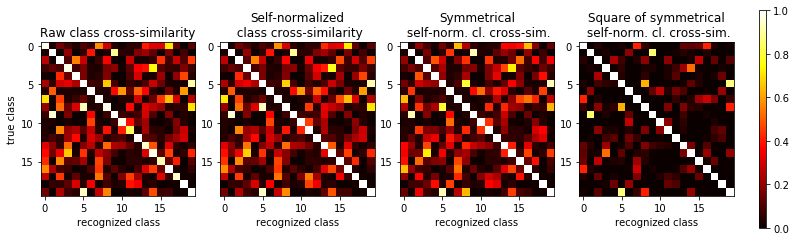

Sum of normalized cross-similarities (excluding diagonal): 63.45369
Sum of squares of normalized cross-similarities (excluding diagonal): 24.725056


In [21]:
s = np.sort(best_glyph_indices)
print(s)
ixgrid = np.ix_(s, s)
similarity_matrix_subset = similarity_matrix[ixgrid]

fig,ax = plt.subplots(1,5,figsize=(13,4),gridspec_kw={"width_ratios":[1,1,1,1, 0.05]})

ax[0].imshow(similarity_matrix_subset, vmin=0, vmax=1, cmap='hot')
similarity_matrix_subset_normself = np.divide(similarity_matrix_subset,np.diagonal(similarity_matrix_subset))
ax[0].set_title("Raw class cross-similarity")
ax[0].set_ylabel("true class"); ax[0].set_xlabel("recognized class")

ax[1].imshow(similarity_matrix_subset_normself, vmin=0, vmax=1, cmap='hot')
ax[1].set_title("Self-normalized\n class cross-similarity"); ax[1].set_xlabel("recognized class")

ax[2].imshow(
    symmetric_harmonic_mean(similarity_matrix_subset_normself),
    vmin=0, vmax=1, cmap='hot'
)
ax[2].set_title("Symmetrical\n self-norm. cl. cross-sim."); ax[2].set_xlabel("recognized class")

ax[3].imshow(
    np.square(symmetric_harmonic_mean(similarity_matrix_subset_normself),), 
    vmin=0, vmax=1, cmap='hot'
)
ax[3].set_title("Square of symmetrical\n self-norm. cl. cross-sim."); ax[3].set_xlabel("recognized class")

fig.colorbar(im,cax=ax[4])
plt.show()

nondiag_sum = np.sum(similarity_matrix_subset_normself) - np.sum(np.diagonal(similarity_matrix_subset_normself))
print('Sum of normalized cross-similarities (excluding diagonal): '+str(nondiag_sum))
nondiag_sq_sum = (
    np.sum(np.square(similarity_matrix_subset_normself)) - 
    np.sum(np.diagonal(np.square(similarity_matrix_subset_normself)))
)
print('Sum of squares of normalized cross-similarities (excluding diagonal): '+str(nondiag_sq_sum))

Ground truth, best glyphs:


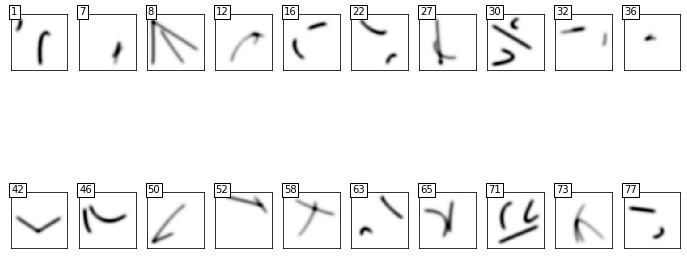

In [22]:
print('Ground truth, best glyphs:')
fig, axs = lilgplt.visualize_glyph_list(
    glyph_mutant_alphabet.selected(s),
    N_glyphs_to_show = N_best_glyphs, 
    imgsize=128, 
    blur_factor=0.5*16,
    figsize=(12,6)
)
plt.show()

In [23]:
def get_N_max_offdiag_elements(input_array, N_max_offdiag):
    arr = np.copy(input_array)
    np.fill_diagonal(arr, 0)
    arr = np.triu(arr)    
    flat_arr = np.copy(arr)
    flat_arr = flat_arr.flatten()
    flat_arr_max_elems = np.argpartition(flat_arr,-N_max_offdiag)[-N_max_offdiag:]
    res_list = [np.unravel_index(flat_arr_max_elems[i],input_array.shape) for i in range(0,N_max_offdiag)]
    return res_list
    
N_worst_offenders = 5
worst_offenders = get_N_max_offdiag_elements(
    similarity_matrix_subset_normself+np.transpose(similarity_matrix_subset_normself), 
    N_worst_offenders
)
worst_offenders_flat = []
for sublist in worst_offenders:
    for item in sublist:
        worst_offenders_flat.append(item)
        
print(worst_offenders)
print(s[worst_offenders_flat])

[(0, 7), (3, 14), (5, 8), (1, 9), (5, 19)]
[ 1 30 12 58 22 32  7 36 22 77]


Ground truth, worst offenders among best glyphs (grouped as pairs):


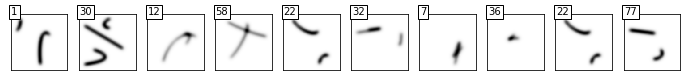

In [24]:
print('Ground truth, worst offenders among best glyphs (grouped as pairs):')
fig, axs = lilgplt.visualize_glyph_list(
    glyph_mutant_alphabet.selected(s[np.array(worst_offenders_flat)]),
    N_glyphs_to_show = N_worst_offenders, 
    imgsize=128, 
    blur_factor=0.5*16,
    figsize=(12,6)
)
plt.show()

In [25]:
glyph_alphabet_new = glyph_mutant_alphabet.selected(s)
glyph_alphabet_new.reset_categories()

In [26]:
#g = [copy.deepcopy(glyph_alphabet_new.glyphs[4]) for i in range(0,N_best_glyphs)]
#glyph_alphabet_new = lilg.GlyphList(g)
#glyph_alphabet_new.reset_categories()